In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import random


In [2]:
BATCH_SIZE = 16
SEED = 6969
dataset_path = "/home/jeff/Documents/Code/StridedTransformer-Pose3D/demo/dataset_pure/"

model_filepath = 'best_model.h5'
# load the model and evaluate test


In [7]:
test = np.load("/home/jeff/Documents/Code/EvoSkeleton-master/examples/keypoints_output/amruth_bad1_3D_86.npz")
print(test['arr_0'])
print(test['arr_0'].shape)

[[   0.            0.            0.        ]
 [ -27.62316035 -166.80894663 -193.46201834]
 [   5.75458259 -380.62777312 -326.25328807]
 [  23.33191977 -501.57423177 -320.3427474 ]
 [   5.75458259 -380.62777312 -326.25328807]
 [ 177.40643575 -350.78924989 -380.24332487]
 [ 283.40266307 -365.04568147 -159.95198192]
 [   5.75458259 -380.62777312 -326.25328807]
 [-211.04830067 -364.07487087 -383.76070525]
 [-412.77762793 -327.63355465 -274.15238511]]
(10, 3)


In [3]:
partition = {
    "train": [],
    "val": [],
    "test": [],
}
labels = {}
random.seed(SEED)
np.random.seed(SEED)
classes = []
good = 0 
ok = 0
bad = 0
test = False
for f in os.listdir(dataset_path):
    rand = random.random()
    # if (rand < 0.05):
        # test = True
        # partition["test"].append(f)
    # elif (rand > 0.1 and rand < 0.3):
    #     test = False
    #     partition["val"].append(f)
    # else:
        # test = False
    partition["train"].append(f)
    if ("ok") in f:
        labels[f] = 1
        ok += 1
        if test: 
            classes.append(1)
    elif ("good") in f:
        labels[f] = 0
        good += 1
        if test: 
            classes.append(0)
    elif ("bad") in f:
        labels[f] = 2
        bad += 1
        if test: 
            classes.append(2)
jeff_val = "/home/jeff/Documents/Code/StridedTransformer-Pose3D/demo/jeff_val/"
daniel_test = "/home/jeff/Documents/Code/StridedTransformer-Pose3D/demo/daniel_test/"

for f in os.listdir(jeff_val):
    partition["val"].append(f)
    # partition["test"].append(f)
    if ("ok") in f:
        labels[f] = 1
        # classes.append(1)
    elif ("good") in f:
        labels[f] = 0
        # classes.append(0)
    elif ("bad") in f:
        labels[f] = 2# classes.append(2)

for f in os.listdir(daniel_test):
    # print(f)
    partition["test"].append(f)
    if ("ok") in f:
        labels[f] = 1
        classes.append(1)
    elif ("good") in f:
        labels[f] = 0
        classes.append(0)
    elif ("bad") in f:
        labels[f] = 2
        classes.append(2)

print(good)
print(ok)
print(bad)
print(len(partition["train"]))
print(len(partition["val"]))
print(len(partition["test"]))
print(len(labels))
# labels

# labels = to_categorical(labels)

35535
38302
35578
109415
1145
573
111133


In [4]:
# ls = ["good", "ok", "bad"]
# output = []
# for t in partition["train"][:100]:
#     if "ok" in t: 
#         reshaped = np.load("/home/jeff/Documents/Code/StridedTransformer-Pose3D/demo/dataset_pure/"+t).reshape(-1,3,1)
#         expanded = np.expand_dims(reshaped, axis=0)
#         predictions = model.predict(expanded, batch_size=1)
#         res = np.argmax(predictions)
#         output.append(ls[res])
# output
        

In [5]:

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, dataset_dir, batch_size=64, dim=(17,3), n_channels=1, n_classes=3, shuffle=True,):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.dataset_dir = dataset_dir
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
        # return len(self.list_IDs)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            f = np.load(self.dataset_dir + ID)
            reshaped = f.reshape(-1,3,1)
            X[i,] = reshaped

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [6]:
params = {
    'dim': (17,3),
    'n_classes': 3,
    'n_channels': 1,
}

train_datagen = DataGenerator(
    partition["train"], 
    labels, 
    dataset_dir=dataset_path,
    batch_size=BATCH_SIZE,
    shuffle=False,
    **params
)
val_datagen = DataGenerator(
    partition["val"],
    labels,
    dataset_dir=jeff_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    **params
)
test_datagen = DataGenerator(
    partition["test"],
    labels,
    dataset_dir=daniel_test,
    batch_size=1,
    dim=(17,3),
    n_channels=1,
    n_classes=3,
    shuffle=False
)
print(len(train_datagen))
print(len(val_datagen))
print(len(test_datagen))

6838
71
573


In [7]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(17,3,1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(layers.MaxPooling2D((2, 2), padding='same'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(3, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 17, 3, 32)         320       
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 3, 32)         9248      
                                                                 
 dense (Dense)               (None, 17, 3, 128)        4224      
                                                                 
 dropout (Dropout)           (None, 17, 3, 128)        0         
                                                                 
 dense_1 (Dense)             (None, 17, 3, 128)        16512     
                                                                 
 dropout_1 (Dropout)         (None, 17, 3, 128)        0         
                                                                 
 flatten (Flatten)           (None, 6528)              0

2022-04-25 13:13:38.859078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 13:13:38.863257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 13:13:38.863429: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 13:13:38.863875: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
model_filepath = 'best_model.h5'
checkpoint = keras.callbacks.ModelCheckpoint('model_saves/model{epoch:05d}.h5', period=2) 
model_save = tf.keras.callbacks.ModelCheckpoint(
    model_filepath,
    monitor = "accuracy",
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = "max",
    save_freq = "epoch"
)
callback = [model_save, checkpoint]

In [9]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=100000,
#     decay_rate=0.95
# )
# 5-e6 SGD
# model.compile(
#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
#     loss = "categorical_crossentropy",
#     metrics = ["accuracy"]
# )
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [10]:
history = model.fit(
    train_datagen,
    epochs = 500,
    steps_per_epoch = len(train_datagen) // BATCH_SIZE,
    validation_data = val_datagen,
    validation_steps = len(val_datagen),
    shuffle = False,
    callbacks = callback,
    # use_multiprocessing = True,
    # workers = 4
)

Epoch 1/500


2022-04-25 13:13:41.643965: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-04-25 13:13:43.754451: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


427/427 [==============================] - 9s 12ms/step - loss: 0.9161 - accuracy: 0.5222 - val_loss: 0.7888 - val_accuracy: 0.5634
Epoch 2/500
427/427 [==============================] - 4s 10ms/step - loss: 0.6802 - accuracy: 0.6950 - val_loss: 0.7248 - val_accuracy: 0.6505
Epoch 3/500
427/427 [==============================] - 4s 10ms/step - loss: 0.5489 - accuracy: 0.7715 - val_loss: 0.6770 - val_accuracy: 0.6805
Epoch 4/500
427/427 [==============================] - 4s 10ms/step - loss: 0.4497 - accuracy: 0.8119 - val_loss: 0.7091 - val_accuracy: 0.6197
Epoch 5/500
427/427 [==============================] - 4s 10ms/step - loss: 0.3683 - accuracy: 0.8532 - val_loss: 0.7206 - val_accuracy: 0.6655
Epoch 6/500
427/427 [==============================] - 5s 11ms/step - loss: 0.3068 - accuracy: 0.8788 - val_loss: 0.8471 - val_accuracy: 0.6752
Epoch 7/500
427/427 [==============================] - 4s 10ms/step - loss: 0.2633 - accuracy: 0.8967 - val_loss: 0.8153 - val_accuracy: 0.7421
Epoc

KeyboardInterrupt: 

In [11]:
model = tf.keras.models.load_model(model_filepath)
test = np.load("/home/jeff/Documents/Code/StridedTransformer-Pose3D/demo/dataset_pure/chris_ok_scaled_1203.npy")
reshaped = test.reshape(-1,3,1)
expanded = np.expand_dims(reshaped, axis=0)
predictions = model.predict(expanded, batch_size=1)
res = np.argmax(predictions)
ls = ["good", "ok", "bad"]
print(ls[res])

ok


In [12]:
plt.figure(figsize = (15,7))

tr_losses = history.history['loss']
val_losses = history.history['val_loss']

tr_accs = history.history['accuracy']
val_accs = history.history['val_accuracy']

plt.plot(tr_losses, label = "train_loss")
plt.plot(val_losses, label = "val_loss")
plt.xlabel("Number of epochs")
plt.ylabel("Cost (J)")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize = (15,7))

plt.plot(tr_accs, label = "acc_train")
plt.plot(val_accs, label = "acc_val")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

NameError: name 'history' is not defined

<Figure size 1080x504 with 0 Axes>

573/573 [==============================] - 3s 4ms/step
              precision    recall  f1-score   support

           0       0.41      0.44      0.42       225
           1       0.50      0.34      0.40       215
           2       0.32      0.45      0.38       133

    accuracy                           0.40       573
   macro avg       0.41      0.41      0.40       573
weighted avg       0.42      0.40      0.41       573

[[ 99   0 126]
 [142  73   0]
 [  0  73  60]]


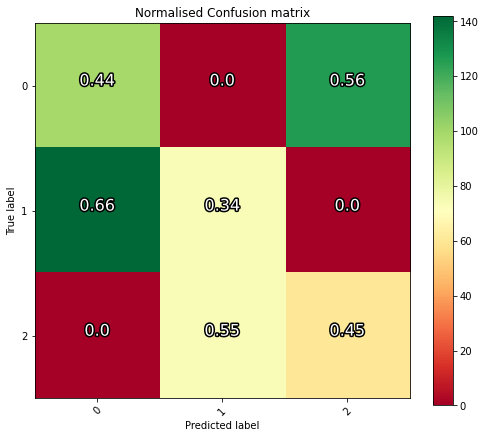

In [14]:
# best_model = tf.keras.models.load_model(model_filepath)
# test_model = tf.keras.models.load_model('model_saves/model00032.h5')
test_model = tf.keras.models.load_model('best_model.h5')
predictions = test_model.predict(
    test_datagen,
    verbose = 1,
    # steps = (len(test_datagen))
)


predictions.squeeze().argmax(axis = -1)
classification__report = classification_report(
    # classes
    classes, 
    predictions.squeeze().argmax(axis = 1)
)
print(classification__report)


confusion__matrix = confusion_matrix(
    classes,
    predictions.squeeze().argmax(axis = 1)
)
print(confusion__matrix)


# Defining a function to print a confusion matrix
# Code snippet referenced from: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
import matplotlib.patheffects as PathEffects
import itertools
def plot_confusion_matrix(cm,
                          classes,
                          normalise = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.RdYlGn):
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalise:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        cm = cm.round(2)

    thresh = cm.max() / 1.1
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        txt =  plt.text(
            j, i, cm[i, j],
            horizontalalignment = "center",
            color = "white",
            size = 16
        )
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='black')])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



np.set_printoptions(precision = 2)
fig2 = plt.figure(figsize = (7,6))
plot_confusion_matrix(confusion__matrix,
                      classes = np.unique(classes),
                      normalise = True,
                      title = 'Normalised Confusion matrix')
plt.show()


# DONT FORGET TO CHANGE WHICH MODEL YOU'RE LOADING